# Electrical Distribution Network Energy Consumption Forecasting based upon Victorian MRIM Meter Data

In this notebook, the Energy Consumption from CitiPower will be forecasted based on Historical Data using Prophet.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from fbprophet import Prophet

In [3]:
data = pd.read_csv('citipower.csv')

In [4]:
df = data[['SETTD','DAILYT']]

In [5]:
df.columns = ['ds','y']
df.head()

,ds,y
0,2014-04-01,6363749.701
1,2014-04-02,5630825.535
2,2014-04-03,5173891.385
3,2014-04-04,5044050.180
4,2014-04-05,4383318.300


In [6]:
df.tail()

,ds,y
2004,2019-09-26,5357014.025
2005,2019-09-27,5219544.620
2006,2019-09-28,5036389.054
2007,2019-09-29,4993439.774
2008,2019-09-30,6030581.529


In [7]:
train = df[:1736]
test = df[1736:]

In [8]:
train.tail()

,ds,y
1731,2018-12-27,5760307.334
1732,2018-12-28,6008568.370
1733,2018-12-29,4330565.457
1734,2018-12-30,3834523.454
1735,2018-12-31,4103400.999


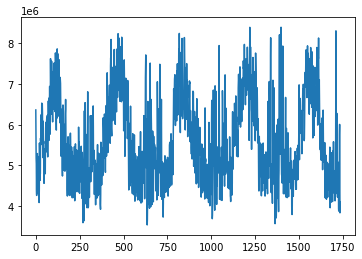

In [9]:
plt.plot(train['y'])

In [10]:
test.head()

,ds,y
1736,2019-01-01,3858957.991
1737,2019-01-02,4264155.819
1738,2019-01-03,4690920.697
1739,2019-01-04,5841792.852
1740,2019-01-05,3913922.670


In [11]:
m = Prophet(yearly_seasonality=False, 
                    weekly_seasonality=False, 
                    daily_seasonality=False
                   ).add_seasonality(name = 'weekly', 
                                      period = 7, 
                                      fourier_order = 25
                    ).add_seasonality(name = 'yearly', 
                                      period = 365.25,
                                      fourier_order = 20
                    )

# .add_seasonality(name = 'monthly', 
#                                      period = 30.5, 
#                                      fourier_order = 10
# .add_seasonality(name = 'quarterly', 
#                                       period = 365.25 / 4, 
#                                       fourier_order = 7,
#                     )
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [12]:
future = m.make_future_dataframe(periods=273)
future.tail()

,ds
2004,2019-09-26
2005,2019-09-27
2006,2019-09-28
2007,2019-09-29
2008,2019-09-30


In [13]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2004,2019-09-26,5.467941e+06,4.782686e+06,6.110479e+06
2005,2019-09-27,5.265113e+06,4.565854e+06,5.955842e+06
2006,2019-09-28,4.590020e+06,3.933464e+06,5.242200e+06
2007,2019-09-29,4.442097e+06,3.761726e+06,5.077116e+06
2008,2019-09-30,5.170384e+06,4.481120e+06,5.887663e+06


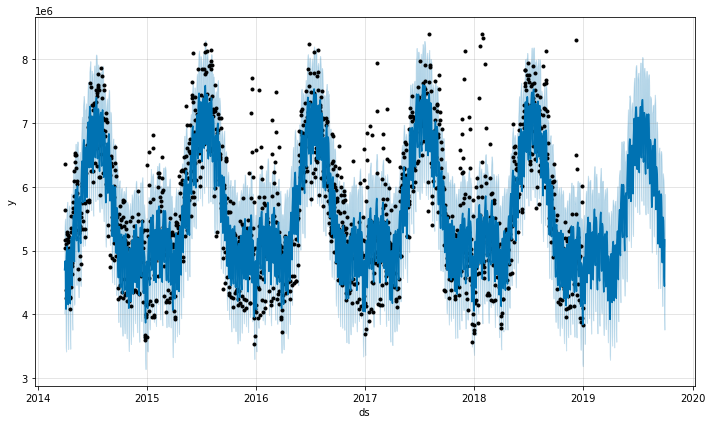

In [14]:
fig1 = m.plot(forecast)

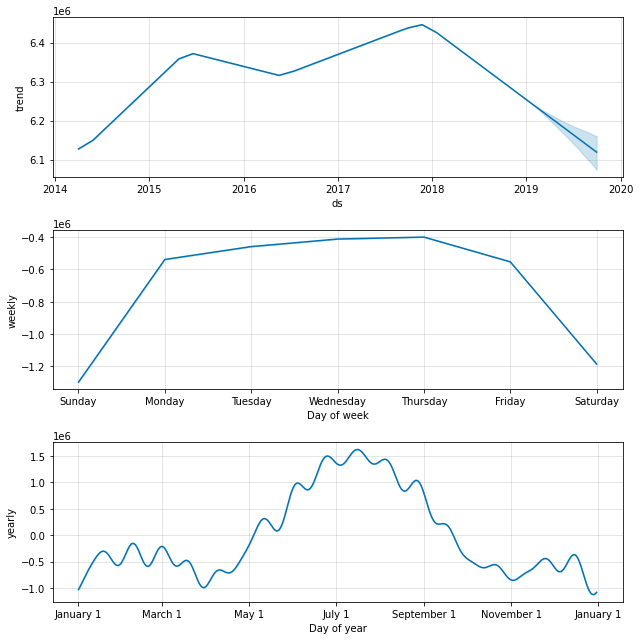

In [15]:
fig2 = m.plot_components(forecast)

# Better look at the test data

In [16]:
predict = forecast[['ds', 'yhat']]
predict.set_index('ds', inplace = True)
predict = predict[predict.index.year == 2019]
trial = test.set_index('ds')
compare = pd.concat([predict, trial], axis = 1)
compare.columns = ['Prediction', 'Actual']
compare

,Prediction,Actual
ds,,
2019-01-01,4.740456e+06,3858957.991
2019-01-02,4.833124e+06,4264155.819
2019-01-03,4.897447e+06,4690920.697
2019-01-04,4.799631e+06,5841792.852
2019-01-05,4.223620e+06,3913922.670
...,...,...
2019-09-26,5.467941e+06,5357014.025
2019-09-27,5.265113e+06,5219544.620
2019-09-28,4.590020e+06,5036389.054


In [17]:
compare.head()

,Prediction,Actual
ds,,
2019-01-01,4.740456e+06,3858957.991
2019-01-02,4.833124e+06,4264155.819
2019-01-03,4.897447e+06,4690920.697
2019-01-04,4.799631e+06,5841792.852
2019-01-05,4.223620e+06,3913922.670


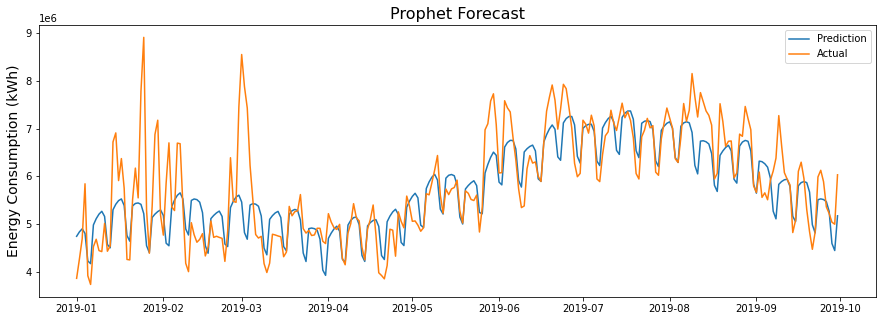

In [18]:
plt.figure(figsize = (15,5))
plt.plot(compare)
plt.title('Prophet Forecast', fontsize = 16)
plt.ylabel('Energy Consumption (kWh)', fontsize = 14)
plt.legend(compare.columns)
plt.show()

# Walk-Forward Validation

In [19]:

# walk-forward validation
history = train.copy()
predictions = pd.DataFrame()


for i in range(len(test)):
# predict
    model = Prophet(yearly_seasonality=False, 
                    weekly_seasonality=False, 
                    daily_seasonality=False
                   ).add_seasonality(name = 'weekly', 
                                      period = 7, 
                                      fourier_order = 25
                    ).add_seasonality(name = 'yearly', 
                                      period = 365.25,
                                      fourier_order = 20
                    )
    model.fit(history)
    future = model.make_future_dataframe(periods=1, include_history = False)
    forecast = model.predict(future)
    predictions = predictions.append(forecast.iloc[-1])

# observation
    obs = test.iloc[i]    #Actual data on this day
    history = history.append(obs)


In [20]:
# predictions[['ds','yhat']]

predict2 = predictions[['ds','yhat']]
predict2.set_index('ds', inplace = True)
trial = test.set_index('ds')
compare2 = pd.concat([predict2, trial], axis = 1)
compare2.columns = ['predict', 'actual']
compare2

,predict,actual
ds,,
2019-01-01,4.740456e+06,3858957.991
2019-01-02,4.804445e+06,4264155.819
2019-01-03,4.845823e+06,4690920.697
2019-01-04,4.744902e+06,5841792.852
2019-01-05,4.213499e+06,3913922.670
...,...,...
2019-09-26,5.580131e+06,5357014.025
2019-09-27,5.396958e+06,5219544.620
2019-09-28,4.709214e+06,5036389.054


Text(0, 0.5, 'Energy Consumption (kWh)')

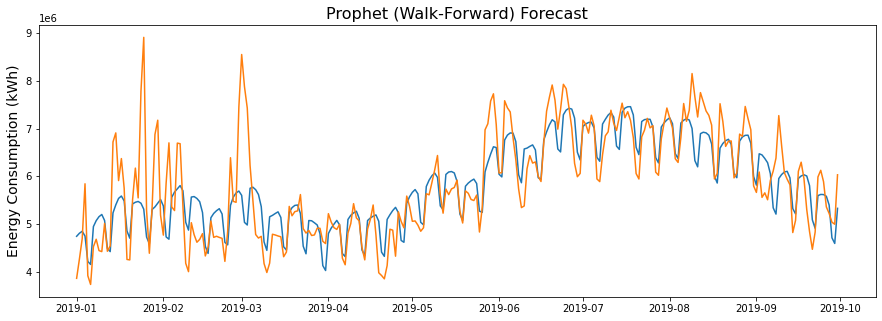

In [21]:
plt.figure(figsize = (15,5))
plt.plot(compare2)
plt.title('Prophet (Walk-Forward) Forecast', fontsize = 16)
plt.ylabel('Energy Consumption (kWh)', fontsize = 14)

- Blue: Prophet (Walk-Forward) Prediction
- Orange: Actual

# Performance Metrics

In [22]:
from sklearn.metrics import r2_score
#############################################
#         evaluation function by AMMAR      #
#############################################
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))

In [23]:
print('Prophet')
regPrintErr(compare['Actual'], compare['Prediction'])

Prophet
R2 Score: 0.6051793623757415
MAPE: 7.770418937500784


In [24]:
print('Prophet (Walk-Forward)')
regPrintErr(compare2['actual'], compare2['predict'])

Prophet (Walk-Forward)
R2 Score: 0.6350538845111984
MAPE: 7.84269905801157


Prophet does not perform well when using a walk forward testing. The model does perform better when forecasting longer periods of time.

The model evaluations are performed in 'Model Evaluation' notebook.

In [25]:
results = {'Actual': compare['Actual'], 'Prophet':compare['Prediction'], 
         'Prophet (Walk-Forward)': compare2['predict']}

In [26]:
results_Prophet = pd.DataFrame(results)

In [27]:
results_Prophet.head()

,Actual,Prophet,Prophet (Walk-Forward)
ds,,,
2019-01-01,3858957.991,4.740456e+06,4.740456e+06
2019-01-02,4264155.819,4.833124e+06,4.804445e+06
2019-01-03,4690920.697,4.897447e+06,4.845823e+06
2019-01-04,5841792.852,4.799631e+06,4.744902e+06
2019-01-05,3913922.670,4.223620e+06,4.213499e+06


In [28]:
results_Prophet.tail()

,Actual,Prophet,Prophet (Walk-Forward)
ds,,,
2019-09-26,5357014.025,5.467941e+06,5.580131e+06
2019-09-27,5219544.620,5.265113e+06,5.396958e+06
2019-09-28,5036389.054,4.590020e+06,4.709214e+06
2019-09-29,4993439.774,4.442097e+06,4.590526e+06
2019-09-30,6030581.529,5.170384e+06,5.326949e+06


In [29]:
results_Prophet.to_csv('results_Prophet.csv')